In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
BASE_DIR=('../input/chest-xray-pneumonia/chest_xray/')
train_dir=os.path.join(BASE_DIR,'train/')
val_dir=os.path.join(BASE_DIR,'val/')
test_dir=os.path.join(BASE_DIR,'test/')

print('Number of images in training set = ',str(len(glob(train_dir+'*/*'))))
print('Number of images in validation set = ',str(len(glob(val_dir+'*/*'))))
print('Number of images in testing set = ',str(len(glob(test_dir+'*/*'))))

Number of images in training set =  5216
Number of images in validation set =  16
Number of images in testing set =  624


In [3]:
training_images = tf.io.gfile.glob('../input/chest-xray-pneumonia/chest_xray/train/*/*')
validation_images = tf.io.gfile.glob('../input/chest-xray-pneumonia/chest_xray/val/*/*')


total_files = training_images
total_files.extend(validation_images)
print(f'Total number of images : training_images + validation_images = {len(total_files)}\n')

#spliting 80:20
train_images, val_images = train_test_split(total_files, test_size = 0.2)
print(f'After division of 80:20')
print(f'Total number of training images = {len(train_images)}')
print(f'Total number of validation images = {len(val_images)}')

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


In [4]:
tf.io.gfile.makedirs('/kaggle/working/val_dataset/NORMAL/')
tf.io.gfile.makedirs('/kaggle/working/val_dataset/PNEUMONIA/')
tf.io.gfile.makedirs('/kaggle/working/train_dataset/NORMAL/')
tf.io.gfile.makedirs('/kaggle/working/train_dataset/PNEUMONIA/')

In [5]:
for ele in train_images:
    parts_of_path = ele.split('/')

    
    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/train_dataset/PNEUMONIA/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/train_dataset/NORMAL/' +  parts_of_path[-1])

In [6]:
for ele in val_images:
    parts_of_path = ele.split('/')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/val_dataset/PNEUMONIA/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/val_dataset/NORMAL/' +  parts_of_path[-1])

In [7]:
print('Pneumonia x-ray images in training set after split = ',len(os.listdir('/kaggle/working/train_dataset/PNEUMONIA/')))
print('Normal x-ray images in training set after split = ',len(os.listdir('/kaggle/working/train_dataset/NORMAL/')))
print('Pneumonia x-ray images in validation set after split = ',len(os.listdir('/kaggle/working/val_dataset/PNEUMONIA/')))
print('Normal x-ray images in validation set after split = ',len(os.listdir('/kaggle/working/val_dataset/NORMAL/')))
print('Pneumonia x-ray images in test set = ',len(os.listdir('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/')))
print('Normal x-ray images in test set = ',len(os.listdir('../input/chest-xray-pneumonia/chest_xray/test/NORMAL')))


Pneumonia x-ray images in training set after split =  3105
Normal x-ray images in training set after split =  1080
Pneumonia x-ray images in validation set after split =  778
Normal x-ray images in validation set after split =  269
Pneumonia x-ray images in test set =  390
Normal x-ray images in test set =  234


In [8]:
train_dir='/kaggle/working/train_dataset/'
val_dir='/kaggle/working/val_dataset/'
test_dir='../input/chest-xray-pneumonia/chest_xray/test/'

train_normal_dir='/kaggle/working/train_dataset/NORMAL'
train_pneumonia_dir='/kaggle/working/train_dataset/PNEUMONIA'
val_normal_dir='/kaggle/working/val_dataset/NORMAL'
val_pneumonia_dir='/kaggle/working/val_dataset/PNEUMONIA'

In [9]:
train_normal_fnames=os.listdir(train_normal_dir)
train_pneumonia_fnames=os.listdir(train_pneumonia_dir)

print(train_normal_fnames[:10])
print(train_pneumonia_fnames[:10])


['NORMAL2-IM-0692-0001.jpeg', 'NORMAL2-IM-0975-0001.jpeg', 'NORMAL2-IM-0900-0001.jpeg', 'NORMAL2-IM-0818-0001-0002.jpeg', 'NORMAL2-IM-0956-0001.jpeg', 'NORMAL2-IM-0693-0001.jpeg', 'NORMAL2-IM-1294-0001.jpeg', 'IM-0672-0001.jpeg', 'NORMAL2-IM-0564-0001.jpeg', 'NORMAL2-IM-1039-0001.jpeg']
['person1639_bacteria_4347.jpeg', 'person984_bacteria_2911.jpeg', 'person656_bacteria_2548.jpeg', 'person604_bacteria_2462.jpeg', 'person1451_virus_2479.jpeg', 'person1473_virus_2553.jpeg', 'person325_bacteria_1500.jpeg', 'person1651_bacteria_4381.jpeg', 'person1074_bacteria_3014.jpeg', 'person477_bacteria_2028.jpeg']


In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

no_cols=4
no_rows=4

pic_index=0

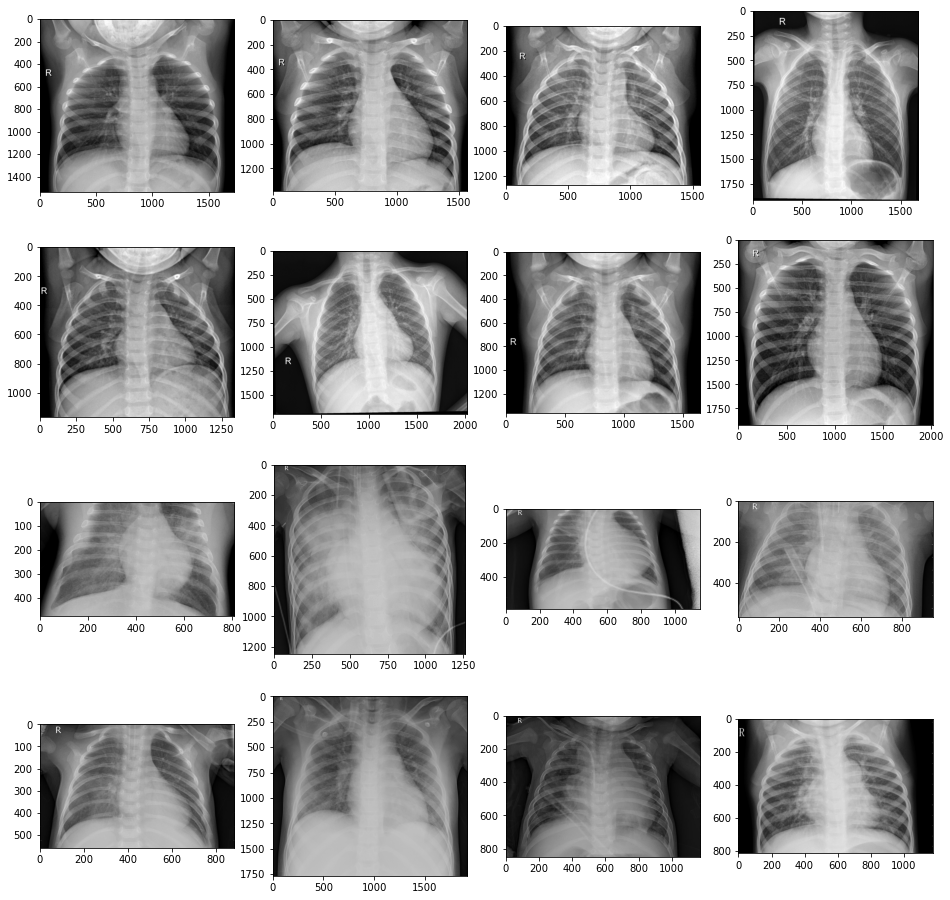

In [11]:
fig=plt.gcf()
fig.set_size_inches(no_cols*4,no_rows*4)

pic_index+=8

normal_pix=[os.path.join(train_normal_dir,fname) for fname in train_normal_fnames[pic_index-8:pic_index]]
pneumonia_pix=[os.path.join(train_pneumonia_dir,fname) for fname in train_pneumonia_fnames[pic_index-8:pic_index]]

for i,img_path in enumerate(normal_pix+pneumonia_pix):
    sp=plt.subplot(no_rows,no_cols,i+1)
    sp.axis()
    
    img=mpimg.imread(img_path)
    plt.imshow(img,cmap='gray')
    
plt.show()

# first 8 images are normal x-ray images and next 8 images are pnemonia x-ray images

In [12]:
model=tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(180, 180, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        3

In [15]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen=ImageDataGenerator(rescale=1.0/255)

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(train_dir,color_mode="grayscale",target_size=(180,180),batch_size=128,class_mode='binary')

val_generator=val_datagen.flow_from_directory(val_dir,color_mode="grayscale",target_size=(180,180),batch_size=128,class_mode='binary')

test_generator=test_datagen.flow_from_directory(test_dir,color_mode="grayscale",target_size=(180,180),batch_size=128,class_mode='binary')

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
history=model.fit(train_generator,validation_data=val_generator,epochs=10,verbose=2)

Epoch 1/10
33/33 - 51s - loss: 0.6134 - accuracy: 0.7243 - precision: 0.7404 - recall: 0.9675 - val_loss: 0.5907 - val_accuracy: 0.7431 - val_precision: 0.7431 - val_recall: 1.0000
Epoch 2/10
33/33 - 52s - loss: 0.5241 - accuracy: 0.7412 - precision: 0.7665 - recall: 0.9366 - val_loss: 0.3728 - val_accuracy: 0.7994 - val_precision: 0.7940 - val_recall: 0.9859
Epoch 3/10
33/33 - 52s - loss: 0.4549 - accuracy: 0.7854 - precision: 0.8264 - recall: 0.8998 - val_loss: 0.3235 - val_accuracy: 0.8539 - val_precision: 0.9671 - val_recall: 0.8316
Epoch 4/10
33/33 - 51s - loss: 0.3853 - accuracy: 0.8179 - precision: 0.8766 - recall: 0.8783 - val_loss: 0.3889 - val_accuracy: 0.8176 - val_precision: 0.8093 - val_recall: 0.9871
Epoch 5/10
33/33 - 52s - loss: 0.3557 - accuracy: 0.8375 - precision: 0.8897 - recall: 0.8915 - val_loss: 0.3518 - val_accuracy: 0.7975 - val_precision: 0.7924 - val_recall: 0.9859
Epoch 6/10
33/33 - 51s - loss: 0.3327 - accuracy: 0.8499 - precision: 0.9073 - recall: 0.8886 -

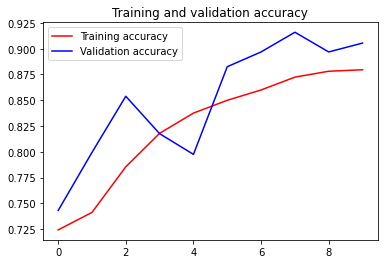

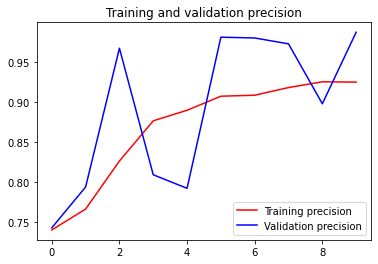

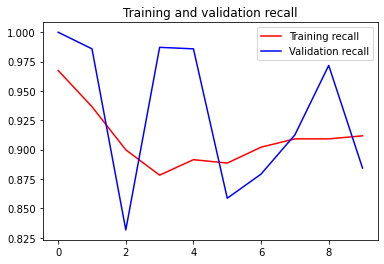

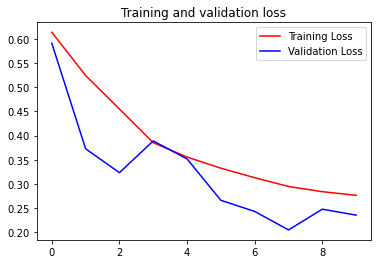

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
eval_result1 = model.evaluate_generator(test_generator, 624)
print('loss  :', eval_result1[0])
print('accuracy  :', eval_result1[1])
print('Precision :', eval_result1[2])
print('Recall :', eval_result1[3])

loss  : 0.3036290109157562
accuracy  : 0.9038461446762085
Precision : 0.920918345451355
Recall : 0.9256410002708435


In [19]:
train_datagen2=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen2=ImageDataGenerator(rescale=1.0/255)

test_datagen2=ImageDataGenerator(rescale=1.0/255)

train_generator2=train_datagen2.flow_from_directory(train_dir,target_size=(180,180),batch_size=128,class_mode='binary')

val_generator2=val_datagen2.flow_from_directory(val_dir,target_size=(180,180),batch_size=128,class_mode='binary')

test_generator2=test_datagen2.flow_from_directory(test_dir,target_size=(180,180),batch_size=128,class_mode='binary')

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [21]:
pretrained_model2 = ResNet50(weights= 'imagenet', include_top=False, input_shape= (180,180,3))

#freazing the trained layers
for layers in pretrained_model2.layers:
    layers.trainable = False
#pretrained_model3.summary()

94773248/94765736 [==============================] - 0s 0us/step


In [22]:
last_layer=pretrained_model2.get_layer('conv5_block3_1_relu')
last_output = last_layer.output

x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2=tf.keras.Model(pretrained_model2.input,x)

model2.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
               metrics=['accuracy','Precision','Recall'])

#model3.summary()

In [23]:
history2=model2.fit(train_generator2,validation_data=val_generator2,epochs=10,verbose=2)

Epoch 1/10
33/33 - 75s - loss: 1.0193 - accuracy: 0.6980 - precision: 0.7475 - recall: 0.8953 - val_loss: 0.5673 - val_accuracy: 0.7431 - val_precision: 0.7431 - val_recall: 1.0000
Epoch 2/10
33/33 - 74s - loss: 0.5968 - accuracy: 0.7257 - precision: 0.7413 - recall: 0.9681 - val_loss: 0.6151 - val_accuracy: 0.7431 - val_precision: 0.7431 - val_recall: 1.0000
Epoch 3/10
33/33 - 74s - loss: 0.5882 - accuracy: 0.7393 - precision: 0.7415 - recall: 0.9958 - val_loss: 0.5793 - val_accuracy: 0.7431 - val_precision: 0.7431 - val_recall: 1.0000
Epoch 4/10
33/33 - 74s - loss: 0.5720 - accuracy: 0.7419 - precision: 0.7419 - recall: 1.0000 - val_loss: 0.5606 - val_accuracy: 0.7431 - val_precision: 0.7431 - val_recall: 1.0000
Epoch 5/10
33/33 - 74s - loss: 0.5670 - accuracy: 0.7240 - precision: 0.7437 - recall: 0.9581 - val_loss: 0.5379 - val_accuracy: 0.7431 - val_precision: 0.7431 - val_recall: 1.0000
Epoch 6/10
33/33 - 74s - loss: 0.5479 - accuracy: 0.7462 - precision: 0.7493 - recall: 0.9887 -

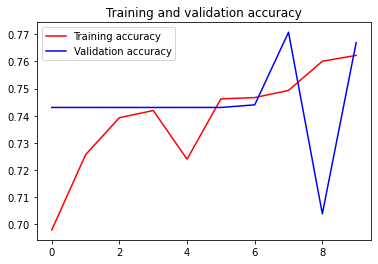

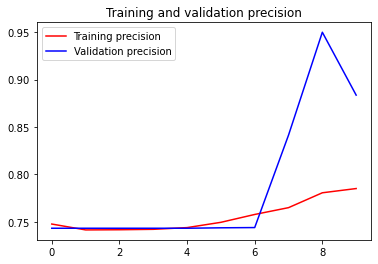

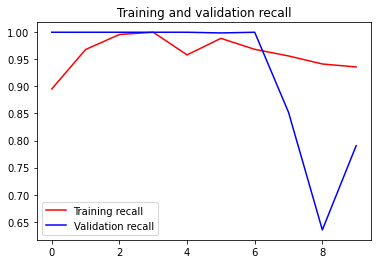

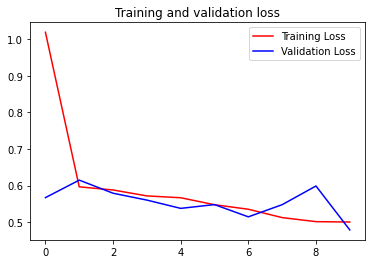

In [24]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

train_precision2=history2.history['precision']
val_precision2=history2.history['val_precision']

train_recall2=history2.history['recall']
val_recall2=history2.history['val_recall']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs = range(len(acc2))

plt.plot(epochs, acc2, 'r', label='Training accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision2, 'r', label='Training precision')
plt.plot(epochs, val_precision2, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall2, 'r', label='Training recall')
plt.plot(epochs, val_recall2, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss2, 'r', label='Training Loss')
plt.plot(epochs, val_loss2, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
eval_result2 = model2.evaluate_generator(test_generator2, 624)
print('loss  :', eval_result2[0])
print('accuracy  :', eval_result2[1])
print('Precision :', eval_result2[2])
print('Recall :', eval_result2[3])

loss  : 0.5033946633338928
accuracy  : 0.7852563858032227
Precision : 0.8152709603309631
Recall : 0.8487179279327393


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import RMSprop
from keras.callbacks import Callback

In [28]:
class ConfusionMatrixCallback(Callback):  # Update this line
    def _init_(self, val_generator):
        super()._init_()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        # Evaluate the model on the validation set
        predictions = self.model.predict(self.val_generator)
        y_pred = np.round(predictions)
        y_true = self.val_generator.classes

        # Compute confusion matrix

In [29]:
# After training, evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

Found 624 images belonging to 2 classes.


In [30]:
# Evaluate the model on the test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)

20/20 [==============================] - 4s 224ms/step - loss: 0.3036 - accuracy: 0.9038 - precision: 0.9209 - recall: 0.9256


In [31]:
# Generate predictions for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

In [32]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred > 0.5)

In [33]:
# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 84 150]
 [148 242]]
